In [1]:
import pickle
import numpy as np
import pandas as pd

### Part 1: Read data

In [2]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [3]:
customer_data = load_obj('/Users/heyifan/Desktop/DBC/2019春季冲刺班/V1-Data Science VIP项目课件-完整版/V1-8节4个Data Project实操项目/项⽬4：推荐系统应用financial_product_recommendation/financial_product_recommendation/data/customer_data')

In [4]:
# 所有用户持有的股票及每支股票的态度 
customer_data

defaultdict(dict,
            {0: {'stocks': ['XRX', 'MDLZ', 'BSX'],
              'positions': [0.32606614433669934,
               0.5543922400879288,
               0.11954161557537196]},
             1: {'stocks': ['OMC', 'JBHT', 'EQIX'],
              'positions': [0.046653199546415745,
               0.8264719435270315,
               0.12687485692655281]},
             2: {'stocks': ['SNA', 'DG', 'NAVI', 'CNC', 'BHGE', 'SEE', 'QRVO'],
              'positions': [0.18720295427033443,
               0.19465233761386325,
               0.15807051329403926,
               0.011318027031826107,
               0.14838416455494802,
               0.19965354308944835,
               0.10071846014554062]},
             3: {'stocks': ['MAS', 'LRCX', 'GE', 'COTY', 'MOS', 'EOG', 'XEC'],
              'positions': [0.23592417092495058,
               0.13312556606137393,
               0.061594045530740764,
               0.1959880332151749,
               0.11165211559896517,
              

### Part 2: Generate Rating dataframe
* Customer's holding could be talked as a rating to one stock. for eg. If customer is holding 70% of position for apple, we could think his rating for apple is 0.7

In [5]:
### loop over data to genrate rating dataframe
# 把list of list变成dataframe格式 
ratingList = []
for customer in customer_data.keys(): # 遍历所有customer编号 
    tmp_data = customer_data[customer] # tmp_data是每个customer的信息 
    for stock, rating in zip(tmp_data['stocks'], tmp_data['positions']): # 遍历每一组信息 
        ratingList.append([customer, stock, rating]) # customer, stock, rating相当于换了一个格式 

In [6]:
df_rating = pd.DataFrame(ratingList, columns=['customerID','stockID','rating'])
df_rating.head()

,customerID,stockID,rating
0,0,XRX,0.326066
1,0,MDLZ,0.554392
2,0,BSX,0.119542
3,1,OMC,0.046653
4,1,JBHT,0.826472


数据格式transformation——spark能接收的形似
* id都必须是数字格式，不能是string

enumerate: 返还两个值：序号 | 值

In [7]:
stock2id = {}
for id, stock in enumerate(df_rating.stockID.unique()): # 遍历所有股票，返回排序和股票名称 
    stock2id[stock] = id

In [8]:
df_rating.stockID = df_rating.stockID.apply(lambda x:stock2id[x])

In [9]:
df_rating.head()

,customerID,stockID,rating
0,0,0,0.326066
1,0,1,0.554392
2,0,2,0.119542
3,1,3,0.046653
4,1,4,0.826472


### Part 3: Collaborative filtering (ALS) with Spark 

ALS model:
- 通过评分矩阵进行推荐
- 将一个产品的稀疏矩阵拆分成：产品矩阵 | 用户评分矩阵

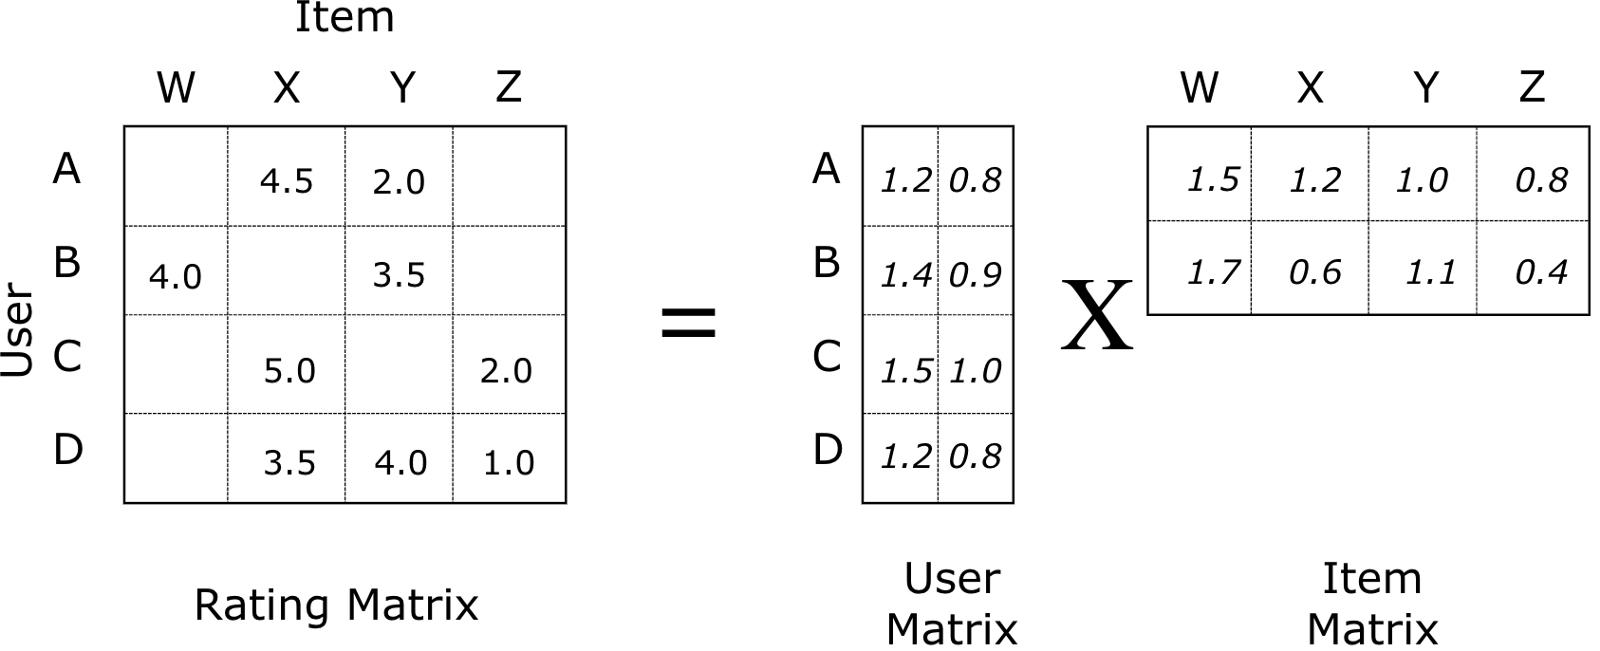

- 优化该方程得到两个feature：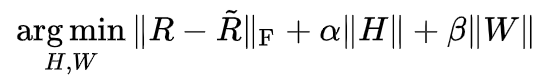

pyspark tutorials: http://spark.apache.org/docs/latest/api/python/index.html

- 如何安装并配置pyspark：https://www.jianshu.com/p/f284b77289ca
- 如何打开bash并配置环境：https://blog.csdn.net/huxinguang_ios/article/details/78709428

In [10]:
!pip install pyspark

In [11]:
import pyspark
from pyspark.sql import SQLContext
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

# mllib model 类似于sklearn 

jdk download: https://www.cnblogs.com/quickcodes/p/5127101.html
jdk environment setting: http://www.cnblogs.com/quickcodes/p/5398709.html

In [12]:
""" Create SparkContext """
### you can only have one sparkContext at the same time
sc = pyspark.SparkContext.getOrCreate()

### create dataframe
sqlContext = SQLContext(sc)

In [13]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [14]:
""" Create Spark dataframe"""
df_spark = sqlContext.createDataFrame(df_rating)
df_spark.printSchema()

root
 |-- customerID: long (nullable = true)
 |-- stockID: long (nullable = true)
 |-- rating: double (nullable = true)



In [15]:
df_rating.head(5)

,customerID,stockID,rating
0,0,0,0.326066
1,0,1,0.554392
2,0,2,0.119542
3,1,3,0.046653
4,1,4,0.826472


至此，df_rating成为了可以直接喂到ALS模型的数据集

#### Matrix Factorization

In [16]:
"""Train ALS model"""
# 生成人的feature和产品的feature 
# rank代表生成的矩阵的维度；5表示生成了5维的矩阵
rank = 5
numIterations = 10
model = ALS.train(df_spark, rank, numIterations)

In [18]:
"""Recommandation based on Users&Products"""
display('features for stock one', model.productFeatures().first())
display('features for user one', model.userFeatures().first())

'features for stock one'

(0,
 array('d', [-0.24196621775627136, 0.16073402762413025, 0.21308931708335876, 0.45060664415359497, -0.13278138637542725]))

'features for user one'

(0,
 array('d', [0.3597647249698639, -0.12306178361177444, 0.04829281195998192, 0.7369741201400757, -0.42723870277404785]))

#### Select target customers for products

In [19]:
# For product x, find N users to sell to 
# 给242号产品选10个最可能的消费者 
stockForUser = model.recommendUsers(242, 10)
print("Top 10 users for product 242: \n")
display(stockForUser)

Top 10 users for product 242: 



[Rating(user=692, product=242, rating=0.4816726608864539),
 Rating(user=238, product=242, rating=0.419853082123157),
 Rating(user=388, product=242, rating=0.40886988194268437),
 Rating(user=992, product=242, rating=0.4085233412155769),
 Rating(user=815, product=242, rating=0.40243094813497393),
 Rating(user=58, product=242, rating=0.39005452533371116),
 Rating(user=171, product=242, rating=0.38951191727431356),
 Rating(user=245, product=242, rating=0.37821130023434724),
 Rating(user=530, product=242, rating=0.3778080280229128),
 Rating(user=390, product=242, rating=0.35123463986281767)]

解释：为产品242 推荐user692 评分为0.48

#### Select target products for customer

In [20]:
# 给196号顾客选10个产品进行推荐
userForStock = model.recommendProducts(196, 10)
print("Top 10 stocks to recommend for user 196")
display(userForStock)

Top 10 stocks to recommend for user 196


[Rating(user=196, product=460, rating=0.34386845336985505),
 Rating(user=196, product=274, rating=0.28047422718202164),
 Rating(user=196, product=307, rating=0.2767636001329519),
 Rating(user=196, product=114, rating=0.2678380899869126),
 Rating(user=196, product=500, rating=0.26087570775369273),
 Rating(user=196, product=327, rating=0.2581490952532585),
 Rating(user=196, product=245, rating=0.25366173383425),
 Rating(user=196, product=171, rating=0.2493307902962716),
 Rating(user=196, product=290, rating=0.2475528281141953),
 Rating(user=196, product=106, rating=0.24417043814272288)]

解释：为user196 推荐产品460 评分为0.34

#### Predicting a new products' ratings of customer 

In [21]:
# 为196号用户预测他对242号产品的评分 
ratingPredict = model.predict(196, 242)

In [22]:
display(ratingPredict)

0.160691163766139

#### 返还所有股票的feature

In [23]:
stockFeatures = model.productFeatures()
stockFeatures.collect()

[(0,
  array('d', [-0.24196621775627136, 0.16073402762413025, 0.21308931708335876, 0.45060664415359497, -0.13278138637542725])),
 (8,
  array('d', [-0.4636642038822174, -0.10046825557947159, 0.31927528977394104, -0.3139296770095825, -0.21005193889141083])),
 (16,
  array('d', [-0.04285367950797081, -0.46202534437179565, 0.12227024883031845, 0.06654108315706253, -0.06062941253185272])),
 (24,
  array('d', [-0.09313174337148666, -0.39629799127578735, 0.0898071750998497, -0.2535708546638489, -0.20129463076591492])),
 (32,
  array('d', [0.0725410059094429, -0.42349037528038025, -0.04243401065468788, -0.3651616871356964, -0.10842109471559525])),
 (40,
  array('d', [0.07388944923877716, -0.5145977735519409, 0.08193834125995636, 0.09376167505979538, -0.007529621012508869])),
 (48,
  array('d', [-0.06063447147607803, -0.21424099802970886, 0.12150555104017258, -0.3409615159034729, -0.14095041155815125])),
 (56,
  array('d', [0.48329976201057434, -0.35511377453804016, 0.4059201776981354, 0.09159

### 现实生活中的应用场景：
- 根据股票的回报率为用户推荐产品

### 缺点：
- 考虑的太片面，仅能通过评分进行推荐

### 升级：
- 电影公司从图像中抽取feature进行推荐

## Part3: Modulize

In [24]:
import pyspark
from pyspark.sql import SQLContext
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
import pandas as pd

class recommendor:
    def __init__ (userIDs, productIDs, ratings, numIterations, rank = 5, sc = None):
        if not sc:
            sc = pyspark.SparkContext.getOrCreate()
        
        self.sc = sc 
        self.df = pd.DataFrame({"userIDs": userIDs, "productIDs": productIDs, "ratings": ratings})
        self.sqlContext = SQLContext(self.sc)
        self.df_spark = sqlContext.createDataFrame(self.df)
        self.rank = rank
        self.numIterations = numIterations
        
        self.model = ALS.train(self.df_spark, self.rank, self.numIterations)
        
    def rating_user_2_product(self, userID, productID):
        return self.model.predict(userID, productID)
    def get_user_features(self, userID):
        return self.model.userFeatures().collect()
    def get_product_features(self, productID):
        return self.model.productFeatures().collect()
    def recommend_users(userID, num_products = 10):
        return self.model.recommendUsers(userID, num_products)
    def recommend_products(productID, num_users = 10):
        return self.model.recommendProducts(productID, num_users)